In [1]:
import warnings
# 仅在这个context里忽略警告
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    from coniii import *
import numpy as np
from tqdm.auto import tqdm
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import random
import generate_assembly #In the same dir
import generate_SpikeCount #In the same dir
from scipy.stats import poisson
import time
import math

warnings.filterwarnings("ignore")


# Define Parameters
T = 3600 # time of simul“ation
dT = 0.5 # time step
params_assembly_density = 3 # size of neurons in each assembly
params_assembly_num =3 # number of assemblies
params_point_into_neuron_distance = 0.5 

# Length of an active event as a number of timesteps
eventDur = np.random.randint(1, 10)
# Probability with which a unit is particularly active in a single timestep
eventProb = np.random.uniform(0.01, 0.05)
# Firing rate multiplier at active events
eventMult = np.random.uniform(6, 10)  # random number between 1 and 5
showPlot = False

In [26]:
def binaryOutput(original_list):
    # Create a new list to hold the tuples
    tuples_list = []

    # Generate all possible combinations of two elements for each sublist
    for sublist in original_list:
        combinations = itertools.combinations(sublist, 2)
        # Convert the combinations into tuples and add them to the list
        tuples_list.extend(tuple(sorted(combination)) for combination in combinations)

    # Remove duplicates by converting the list to a set then back to a list
    unique_tuples = list(set(tuples_list))
    
    return unique_tuples

In [52]:
N = [25,36,49, 64, 81, 100]

assemblies_list = []
spikeCount_list = []
binary_list = []

for n in N:
    fire_rate_background = np.random.uniform(1, 6, n)
    # Here's some preparatory code, we don't count its execution time
    assemblies = generate_assembly.generate_assembly_solve(n, params_assembly_num, params_assembly_density)
    # Output 0, 1 type spikes
    spikeCount = generate_SpikeCount.generateSpikeCountSolve(n, T, dT, assemblies, (1, 6), eventDur, eventProb, eventMult, showPlot)
    # Transform to -1, 1 distribution
    spikeCount[spikeCount == 0] = -1
    assemblies_list.append(assemblies)
    spikeCount_list.append(spikeCount)
    
    binary_list.append(binaryOutput(assemblies))

print(assemblies_list)
print()
print(binary_list)

[[[6, 7, 9], [4, 9], [6, 3]], [[20, 9, 21], [21, 29], [20, 3]], [[5, 6], [18, 12, 6], [11, 5, 19]], [[36, 53, 45], [28, 45], [52, 45]], [[41, 68, 69], [78, 69], [77, 68]], [[58, 78, 89], [97, 78], [68, 78]]]

[[(4, 9), (7, 9), (6, 7), (3, 6), (6, 9)], [(21, 29), (3, 20), (9, 21), (9, 20), (20, 21)], [(6, 12), (6, 18), (5, 11), (11, 19), (5, 6), (5, 19), (12, 18)], [(36, 53), (45, 52), (28, 45), (36, 45), (45, 53)], [(68, 69), (41, 69), (41, 68), (69, 78), (68, 77)], [(68, 78), (78, 97), (58, 78), (78, 89), (58, 89)]]


In [53]:
# Define a function to encapsulate the code you want to time
def code_to_time(spikeCount,threshold):
    solver = ClusterExpansion(spikeCount)
    multipliers, ent, clusters, deltaSdict, deltaJdict= solver.solve(threshold, full_output=True)
    return clusters

In [71]:


# 假设你已经有一个spikeCount_list和threshold
threshold = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

# # 创建一个字典，用于存储每个阈值的结果
results = {thresh: {'accuracy': []} for thresh in threshold}

for thresh in threshold:
    iter_ratio = []
    for i in range(len(spikeCount_list)):
        
        # 执行你的函数
        result = code_to_time(spikeCount_list[i], thresh)

        set1 = set([tuple(sublist) for sublist in result[2]])
        set2 = set(binary_list[i])
        # 计算重复度的比率
        if len(set1) == 0:
            dup_ratio = 0
        else:
            dup_ratio = len(set1 & set2) / len(set2)

        iter_ratio.append(dup_ratio)
        print(set1, "--",set2, dup_ratio)
        print("--------------------")

        # 计算平均时间并添加到阈值的结果字典
    results[thresh]['accuracy'].extend(iter_ratio)

set() -- {(4, 9), (7, 9), (6, 7), (3, 6), (6, 9)} 0
--------------------
set() -- {(21, 29), (3, 20), (9, 21), (9, 20), (20, 21)} 0
--------------------
set() -- {(6, 12), (6, 18), (5, 11), (11, 19), (5, 6), (5, 19), (12, 18)} 0
--------------------
set() -- {(36, 53), (45, 52), (28, 45), (36, 45), (45, 53)} 0
--------------------
set() -- {(68, 69), (41, 69), (41, 68), (69, 78), (68, 77)} 0
--------------------
set() -- {(68, 78), (78, 97), (58, 78), (78, 89), (58, 89)} 0
--------------------
{(7, 9)} -- {(4, 9), (7, 9), (6, 7), (3, 6), (6, 9)} 0.2
--------------------
set() -- {(21, 29), (3, 20), (9, 21), (9, 20), (20, 21)} 0
--------------------
{(11, 19), (12, 18)} -- {(6, 12), (6, 18), (5, 11), (11, 19), (5, 6), (5, 19), (12, 18)} 0.2857142857142857
--------------------
{(36, 53)} -- {(36, 53), (45, 52), (28, 45), (36, 45), (45, 53)} 0.2
--------------------
set() -- {(68, 69), (41, 69), (41, 68), (69, 78), (68, 77)} 0
--------------------
{(58, 89)} -- {(68, 78), (78, 97), (58, 7

In [99]:
results

{0.5: {'accuracy': [0, 0, 0, 0, 0, 0]},
 0.1: {'accuracy': [0.2, 0, 0.2857142857142857, 0.2, 0, 0.2]},
 0.05: {'accuracy': [1.0, 1.0, 0.8571428571428571, 0.6, 0.8, 0.8]},
 0.01: {'accuracy': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]},
 0.005: {'accuracy': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]},
 0.001: {'accuracy': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}}

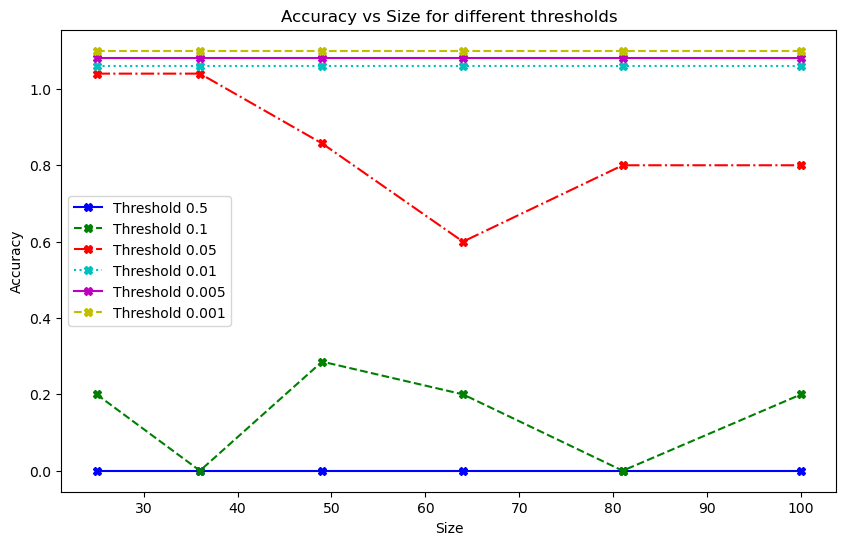

In [103]:
# Different line styles and colors
plt.figure(figsize=(10, 6))

line_styles = ['-', '--', '-.', ':']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for index, (threshold, data) in enumerate(results.items()):
    plt.plot(N, [acc + 0.02 * index if acc == 1.0 else acc for acc in data['accuracy']], line_styles[index % len(line_styles)], color=colors[index % len(colors)], label=f'Threshold {threshold}', marker = "X")

plt.xlabel('Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Size for different thresholds')
plt.legend(loc='center left')

plt.show()


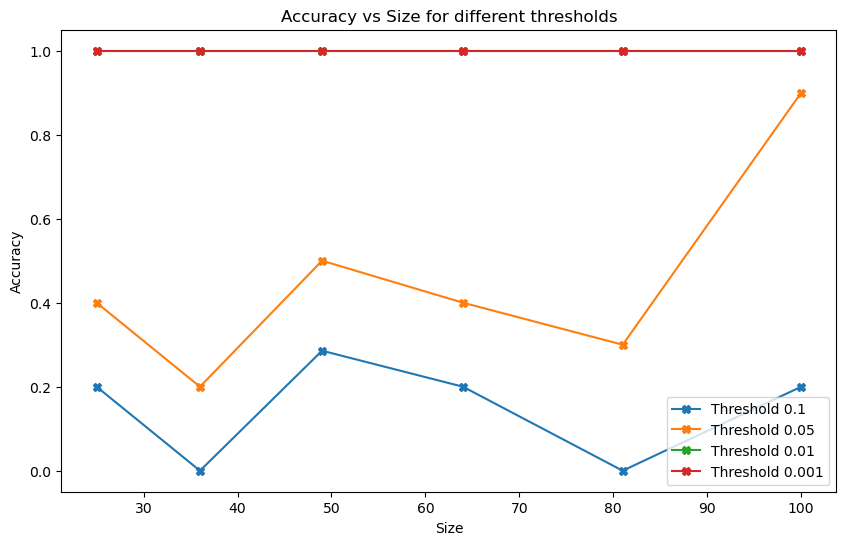

In [93]:
import matplotlib.pyplot as plt

data_dict = {
    0.1: {'accuracy': [0.2, 0, 0.2857142857142857, 0.2, 0, 0.2]},
    0.05: {'accuracy': [0.4, 0.2, 0.5, 0.4, 0.3, 0.9]},
    0.01: {'accuracy': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]},
    0.001: {'accuracy': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]},
}

sizes = [25, 36, 49, 64, 81, 100]

plt.figure(figsize=(10, 6))

for threshold, data in data_dict.items():
    plt.plot(sizes, data['accuracy'], label=f'Threshold {threshold}', marker='X')

plt.xlabel('Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Size for different thresholds')
plt.legend()

plt.show()
